# Project 2: Violence against Women in Germany

Nearly every day a woman is killed in Germany. Also, every third woman becomes a victim of sexualized or physical violence in the course of her life. However, these figures often remain abstract. That's why I scraped police reports from all over Germany for a week - and, with the support of AI, analyzed how many and what types of crimes against women were reported in this week alone.

## Step 1: Import Libraries

In [ ]:
import os
from playwright.async_api import async_playwright, expect
import pandas as pd
import re
from dotenv import load_dotenv
load_dotenv()
from openai import OpenAI
from IPython.display import display, Markdown
from tqdm.auto import tqdm
tqdm.pandas()
from enum import Enum, IntEnum
from strip_tags import strip_tags
import tiktoken
from pydantic import BaseModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_score, recall_score
import geocoder

## Step 2: Scraping Police Reports from all over Germany
Data source: presseportal.de (news aktuell GmbH)

Observation period: 06/30/2025 to 07/06/2025

In [ ]:
async def open_browser(headless=False):
    """
    Starts the automated browser and opens a new window
    """
    playwright = await async_playwright().start()
    browser = await playwright.chromium.launch(headless=False)
    context = await browser.new_context(user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36")
    page = await browser.new_page()
    return browser, page

In [ ]:
driver, page = await open_browser()

In [ ]:
url = 'https://www.presseportal.de/blaulicht/?startDate=2025-06-30&endDate=2025-07-06'
await page.goto(url)

In [ ]:
rows = []
page_counter = 1
while True:
    print(f"📄 Look at page {page_counter} …")
    articles = await page.locator('//article[@class="news"]').all()
    for article in articles:
        row = {}
        row['headline'] = await article.locator('xpath=.//h3/a[@title]').get_attribute("title")
        try:
            row['description'] = await article.locator('xpath=.//p[2]').text_content()
        except:
            row['description'] = "NaN"
        try:
            row['location'] =  await article.locator("xpath=.//a[@class='news-topic event-trigger no-child-trigger']").text_content()
        except:
            row['location'] = "NaN"
        try:
            row['date_time'] =  await article.locator('xpath = .//div[@class="date"]').text_content()
        except:
            row['date_time'] = "NaN"
        rows.append(row)
    page_counter += 1
    next_button = page.locator('//span[@class="btn pagination-next"]')
    if not await next_button.count():
        break
    next_url = await next_button.get_attribute("data-url")
    if not next_url:
        break
    clean_url = next_url.lstrip("@")
    if not clean_url.startswith("/"):
        clean_url = "/" + clean_url
    full_url = f"https://www.presseportal.de{clean_url}"
    await page.goto(full_url, timeout=60000, wait_until="domcontentloaded")
    await page.wait_for_selector("article.news", timeout=30000)
    await page.wait_for_timeout(1000)

In [ ]:
df = pd.DataFrame(rows)

In [ ]:
df.to_csv('week.csv', index=False)

## Step 3: Clean the data

In [ ]:
df = pd.read_csv("week.csv")

In [ ]:
# Delete internal abbreviations for police stations at the beginning of "headline" column
df["headline"] = df["headline"].str.replace(r"^.*?:\s", "", regex = True)

In [ ]:
# Delete the locations at the beginning of the "description" column
df["description"] = df["description"].str.replace(r"^.*?-\s", "", regex = True)

In [ ]:
# Replace NAs
df['description'] = df['description'].fillna('Keine Beschreibung vorhanden.')
df['description'].isna().value_counts()

In [ ]:
# Merge headline and description to a variable called "text"
df['text'] = df.apply(lambda row: 'Headline: ' + row['headline'] + '\n\nDescription: ' + row['description'], axis=1)

In [ ]:
## Format date_time
df['date_time'] = pd.to_datetime(df['date_time'],format='%d.%m.%Y – %H:%M')

## Step 4: Categorization of "Violence against Women" with an AI model

### Categorization "Violence against Women" vs. "No Violence against Women"

In [ ]:
# Set Up API Key
api_key = os.getenv("API_KEY")
client = OpenAI(api_key=api_key)

In [ ]:
# Define the Text Column Name
text_column_name = "text"

In [ ]:
# Create a Sample File for Testing
SIZE_OF_SAMPLE = 400
df_sample = df.sample(n=SIZE_OF_SAMPLE)

In [ ]:
# Create my Options
class PoliceReportOptions(str, Enum):
    women_violence = "Violence against Women"
    no_women_violence = "No Violence against Women"

In [ ]:
# Basic Prompt
prompt_base = """

These are police reports from Germany: {report_text} Please categorize them, and choose only from these options: {categories}

Examples:

Text: "Headline: Sexuelle Belästigung - Bundespolizei stellt Tatverdächtigen im Hauptbahnhof \n\nDescription:  Am Montagmittag (30. Juni) soll ein 66-jähriger Münsteraner ein 16-jähriges Mädchen im Vorbeigehen unsittlich berührt haben. Den Angaben der Jugendlichen zufolge, überquerte sie die Ampelanlage vor dem Hauptbahnhof in Richtung Windthorststraße, als der Mann sie angerempelt und an den Hintern gefasst haben soll. Der Mann verschwand anschließend ..."
Classification: "Violence against Women"

Text: "Headline: Asperg: 25-Jähriger masturbiert in Schwimmbad - Polizei ermittelt \n\nDescription: Weil er sexuelle Handlungen vor Kindern vorgenommen hat, wird sich ein 25-jähriger Mann wegen des sexuellen Missbrauchs von Kindern verantworten müssen. Der 25-Jährige befand sich am Mittwoch (02.07.2025) gegen 17.00 Uhr im Freibad in Asperg im Nichtschwimmerbecken auf einer Sprudelliege und masturbierte. Dies konnte zunächst ein 13-Jähriger ..."
Classification: "No Violence against Women"

Text: "Headline: Kamen - Polizei ermittelt Tatverdächtigen nach Beziehungsstreit \n\nDescription: Kamen (ots) - Am Dienstag (01.07.2025) kam es gegen 19.10 Uhr zu Beziehungsstreitigkeiten zwischen einer 38-Jährigen Ukrainerin aus Lünen und einem 55-Jährigen Usbeken aus Dortmund. Ausgetragen wurde der Streit in einem Lebensmittelgeschäft an der Königsberger Straße in Kamen-Mitte. Der Mann kam dorthin mit der Absicht, ein Gespräch mit seiner Ex-Frau führen zu ..."
Classification: "Violence against Women"

Text: "Headline: Pressemeldungen aus dem Bereich Cloppenburg \n\nDescription: Löningen - Diebstahl von Kupferkabeln Am Dienstag, 01. Juli 2025 gegen 07:15 Uhr meldete eine 54-jährige Frau aus Löningen, dass drei männliche Personen Kupferkabel von ihrem Grundstück in der Herzlaker Straße entwendet hätten. Einer der Männer konnte wie folgt beschrieben werden: - ca. 165-175cm groß - schlank - ca. 25 Jahre - dunkle Hose - weißes T-Shirt Die Männer entfernten sich ..."

Please check your answers carefully.

"""

In [ ]:
# Create a column in the dataframes with the prompt for each item

df_sample_prompt_column = df_sample.apply(lambda row: prompt_base.format(
    report_text=row[text_column_name],
    categories=", ".join(['"{}"'.format(opt.value) for opt in PoliceReportOptions])
), axis="columns")

df_prompt_column = df.apply(lambda row: prompt_base.format(
    report_text=row[text_column_name],
    categories=", ".join(['"{}"'.format(opt.value) for opt in PoliceReportOptions])
), axis="columns")

In [ ]:
# Set Up Cost Estimation

def count_tokens(model, text):
    encoding = tiktoken.encoding_for_model(model if model != 'gpt-4.1-mini' else 'gpt-4o')
    tokens = encoding.encode(text)
    return len(tokens)

input_token_costs = {
    "gpt-4.1-mini": 0.4 / 1_000_000,  # https://openai.com/api/pricing/
    "mistral-medium-latest": 0.4 / 1_000_000, # https://mistral.ai/pricing#api-pricing
    "mistral-large-latest": 2.0 / 1_000_000
}
def estimate_cost(model, token_count):
    return token_count * input_token_costs[model]

MODEL_TO_USE = 'gpt-4.1-mini'

count_tokens_for_our_model = lambda text: count_tokens(MODEL_TO_USE, text)

In [ ]:
# Cost Estimation Sample
token_count_sample = count_tokens_for_our_model("SAMPLE RESPONSE SAMPLE RESPONSE".join(df_sample_prompt_column))
"Sample would cost: ${:.2f}".format(estimate_cost(MODEL_TO_USE, token_count_sample))

In [ ]:
# Cost Estimation Full Data
token_count_full = count_tokens_for_our_model("SAMPLE RESPONSE SAMPLE RESPONSE".join(df_prompt_column))
"Full dataset would cost: ${:.2f}".format(estimate_cost(MODEL_TO_USE, token_count_full))

In [ ]:
# Send the Prompt To OpenAI

class PoliceReportValidOptions(BaseModel):
  classification: PoliceReportOptions

def classify(prompt_including_tweet):

    messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant.",
        },
        {
            "role": "user",
            "content": prompt_including_tweet,
        }
    ]

    chat_completion = client.responses.parse(
        input=messages,
        model='gpt-4o',
        text_format=PoliceReportValidOptions,
    )

    resp = chat_completion.output_parsed.classification.value if chat_completion.output_parsed else None
    return resp

In [ ]:
# Classify every report in the sample
df_sample["ai_guess"] = df_sample_prompt_column.progress_apply(classify)

In [ ]:
# Download the Data for Hand Classification
df_sample["groundtruth"] = ""
df_sample.to_csv('df_sample_for_hand_classification.csv')

In [ ]:
# Upload the Data again after Hand Classification
handcoded = pd.read_csv("df_sample_hand_classified.csv", sep=";")

In [ ]:
# Accuracy Score
display(Markdown("Accuracy score: {:.1%}.".format(
    accuracy_score(handcoded["groundtruth"], handcoded["ai_guess"])
)))

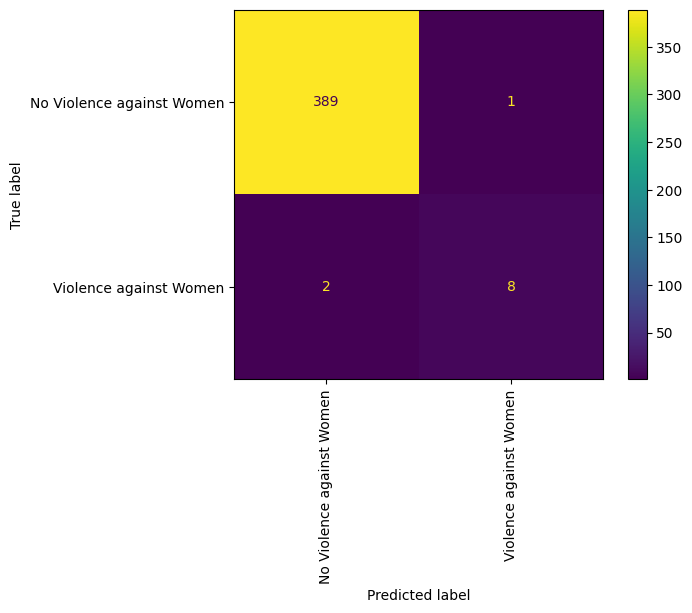

In [70]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(handcoded["groundtruth"], handcoded["ai_guess"],  xticks_rotation="vertical")

In [76]:
# Compare Baseline and Accuracy
accuracy = accuracy_score(handcoded["groundtruth"], handcoded["ai_guess"])
most_common_answer = handcoded.groupby("groundtruth").count().idxmax().ai_guess
baseline = accuracy_score(handcoded["groundtruth"], [most_common_answer] * len(handcoded["ai_guess"]))
print(f'Accuracy: {accuracy}')
print(f'Baseline: {baseline}')

Accuracy: 0.9925
Baseline: 0.975


In [80]:
# Calculate Precision Score
precision_score(handcoded["groundtruth"] == PoliceReportOptions.women_violence, handcoded["ai_guess"] == PoliceReportOptions.women_violence)

0.8888888888888888

In [82]:
# Calculate Recall Score
recall_score(handcoded["groundtruth"] == PoliceReportOptions.women_violence, handcoded["ai_guess"] == PoliceReportOptions.women_violence)

0.8

In [ ]:
# Classify the whole dataset
df_prompt_column = prompt_base + df[text_column_name]
df["ai_guess"] = df_prompt_column.progress_apply(classify)

In [ ]:
# Filter for Violence against women
df_filtered = df[df['ai_guess']=='Violence against Women']

In [ ]:
# Download the Dataset to check manually whether all reports classified as "violence against women" are indeed "violence against women".
# By my definition, "violence against women" must be a central part of the crime. A robbery involving a woman, for example, would not be.
df_filtered.to_csv('df_filtered_for_hand_classification.csv')

In [ ]:
# Upload the factchecked data
df_factchecked = pd.read_csv("df_filtered_factchecked.csv", sep=";")

In [ ]:
# Filter factchecked Data for "Violence against women"
df_factchecked_filtered = df_factchecked[df_factchecked['factcheck']=='Violence against Women']

In [ ]:
# Keep only variables needed
df_factchecked_filtered = df_factchecked_filtered.drop(columns=['ai_guess', 'factcheck'])

### Categorization: Public vs. Private Environment

I want to categorize whether the crime occured in the private environment of a woman or in the public.

The AI model is supposed to perform an initial sorting, but in this case I will check all the data again by hand. That is why I am not calculating any accuracy scores in this case.

In [ ]:
# Redefine Text Column
text_column_name = "text"

In [ ]:
# Create my Options
class PublicPrivateOptions(str, Enum):
    public = "in public"
    non_public = "private environment"
    other = "relationship unclear"

In [ ]:
# Basic Prompt
prompt_base = """

These are police reports from Germany, covering violence against women: {report_text} Please categorize them, and choose only from these options: {categories}
"in public" means that the woman did not know the perpetrator. "private environment" means the woman did know her perpetrator before. "relationship unclear" means that the report does not include information on the relation between victim and perpretator.

Examples:

Text: "Headline: Sexuelle Belästigung im Schlosspark Celle - Zeugen gesucht \n\nDescription: Celle - Am Dienstag, den 01.07.2025, ist es zwischen 16:30 und 17:10 Uhr im Schlosspark Celle durch einen unbekannten männlichen Täter zu einer sexuellen Belästigung gekommen. Der Mann soll zwei 13-jährigen Mädchen von der Stechbahn bis zum Spielplatz im Schlosspark gefolgt sein. Dabei hat er sich immer wieder in den Schritt gefasst und den Mädchen zugewunken. Im Anschluss hat der Mann auf dem ..."
Classification: "in public"

Text: "Headline: Einsatz am Platz der Republik \n\n Description: Am frühen Freitagabend geriet ein 27-Jähriger aus Gera mit seiner 22-jährigen Ex-Freundin auf einem Spielplatz in der Geraer Innenstadt in Streit und beleidigte diese. Die Situation blieb einigen Passanten nicht unbemerkt. Sie forderten den Aggressor auf, die junge Frau in Ruhe zu lassen. Wutentbrannt entfernte sich der Herr einige Meter, nur um mit einer Gruppe Jugendlicher die nächste Auseinandersetzung ..."
Classification: "private environment"

Text: "Headline: Darmstadt: In Umkleidekabine fotografiert/Polizei nimmt 55-Jährigen fest \n\nDescription: Eine 19 Jahre alte Frau bemerkte am Freitagnachmittag (04.07.), kurz vor 15.30 Uhr, dass ein Mann in einer Umkleidekabine des Nordbads in der Alsfelder Straße heimlich Fotos von ihr fertigte. Sie verständigte daraufhin sofort Angestellte des Schwimmbads. Der 55 Jahre alte Verdächtige aus dem ..."
Classification: "relationship unclear"

Please check your answers carefully.

"""

In [ ]:
# Create a column in my dataframe with the prompt for each item

df_factchecked_filtered_column = df_factchecked_filtered.apply(lambda row: prompt_base.format(
    report_text=row[text_column_name],
    categories=", ".join(['"{}"'.format(opt.value) for opt in PublicPrivateOptions])
), axis="columns")

In [ ]:
# Cost Estimation Set Up

def count_tokens(model, text):
    encoding = tiktoken.encoding_for_model(model if model != 'gpt-4.1-mini' else 'gpt-4o')
    tokens = encoding.encode(text)
    return len(tokens)

input_token_costs = {
    "gpt-4.1-mini": 0.4 / 1_000_000,  # https://openai.com/api/pricing/
    "mistral-medium-latest": 0.4 / 1_000_000, # https://mistral.ai/pricing#api-pricing
    "mistral-large-latest": 2.0 / 1_000_000
}
def estimate_cost(model, token_count):
    return token_count * input_token_costs[model]

MODEL_TO_USE = 'gpt-4.1-mini'

count_tokens_for_our_model = lambda text: count_tokens(MODEL_TO_USE, text)

In [ ]:
# Cost Estimation
token_count_full = count_tokens_for_our_model("SAMPLE RESPONSE SAMPLE RESPONSE".join(df_factchecked_filtered_column))
"Full dataset would cost: ${:.2f}".format(estimate_cost(MODEL_TO_USE, token_count_full))

In [ ]:
# Send the Prompt To OpenAI

class PublicPrivateValidOptions(BaseModel):
  classification: PublicPrivateOptions

def classify(prompt_including_tweet):

    messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant.",
        },
        {
            "role": "user",
            "content": prompt_including_tweet,
        }
    ]

    chat_completion = client.responses.parse(
        input=messages,
        model='gpt-4o',
        text_format=PublicPrivateValidOptions,
    )

    resp = chat_completion.output_parsed.classification.value if chat_completion.output_parsed else None
    return resp

In [ ]:
# Classify every report in the sample
df_factchecked_filtered["ai_guess"] = df_factchecked_filtered_column.progress_apply(classify)

In [ ]:
# Export for Manual Factcheck
df_factchecked_filtered["factcheck_publicprivate"] = ""
df_factchecked_filtered.to_csv('df_factchecked_filtered_for_hand_classification.csv')

In [ ]:
# Load the factchecked dataset back into notebook
df_factchecked_publicprivate = pd.read_csv("df_factchecked_publicprivate.csv", sep=";")

In [ ]:
# Keep only variables needed
df_factchecked_publicprivate = df_factchecked_publicprivate.drop(columns=['ai_guess'])

### Classification of Form of Violence

I want to categorize which form of violence occured to the women.

The AI model is supposed to perform an initial sorting, but in this case I will check all the data again by hand. That is why I am not calculating any accuracy scores in this case.

In [ ]:
# Redefine Text Column
text_column_name = "text"

In [ ]:
# Create my Options
class ViolenceOptions(str, Enum):
    death = "homicide"
    physical = "physical violence (e.g. stabbing, rape)"
    harassment = "harassment (e.g. verbal, exhibitionism)"

In [ ]:
# Basic Prompt

prompt_base = """

These are police reports from Germany, covering violence against women: {report_text} Please categorize them, and choose only from these options: {categories}

Examples:

Text: "Headline: 1/2 Sexuelle Belästigung: Mann entkleidet sich im ICE und belästigt anschließend Bundespolizistin sexuell \n\n Description: Nach jetzigem Sachstand der Hamburger Bundespolizei soll am 05.07.2025 gegen 06:58 Uhr ein stark alkoholisierter Mann (Alter: 26 Jahre) sich in einem im Bahnhof Harburg auf Gleis 4 stehenden ICE entkleidet haben. Der betroffene Zug fuhr auf der Strecke Hamburg-Dammtor - Basel. Der marokkanische ..."
Classification: "harassment (e.g. verbal, exhibitionism)"

Text: "Headline: 04.07.2025-2-PD NMS- Zeugenaufruf nach Körperverletzung im Freibad Büdelsdorf \n\n Description: Am Mittwochabend ist es im Freibad in Büdelsdorf zu einer Körperverletzung gekommen. Eine Mitarbeiterin des Freibades wurde hierbei von einem Jugendlichen ins Gesicht geschlagen. Am 02.07.2025, gegen 19:45 Uhr kam es im Freibad in Büdelsdorf zu einer Körperverletzung. Nach ersten ..."
Classification: "physical violence (e.g. stabbing, rape)"

Text: "Headline: Dorsten: Frau und Kleinkind tot aufgefunden - Nachtragsmeldung \n\n Description: Gemeinsame Presseerklärung der Staatsanwaltschaft Essen und des Polizeipräsidiums Recklinghausen: Nach dem Fund einer leblosen Frau und eines leblosen Kindes am Sonntag (29.06.2025) gibt es neue Erkenntnisse. Bei der Frau handelt es sich um eine 32-jährige Ukrainerin, bei dem Kind um ihre 1 Jahr und 7 Monate alte Tochter. Beide wohnten in ..."
Classification: "homicide"

Please check your answers carefully.

"""

In [ ]:
# Make a column in my dataframe with the prompt for each item
df_factchecked_publicprivate_column = df_factchecked_publicprivate.apply(lambda row: prompt_base.format(
    report_text=row[text_column_name],
    categories=", ".join(['"{}"'.format(opt.value) for opt in ViolenceOptions])
), axis="columns")

In [ ]:
# Cost Estimation Set Up

def count_tokens(model, text):
    encoding = tiktoken.encoding_for_model(model if model != 'gpt-4.1-mini' else 'gpt-4o')
    tokens = encoding.encode(text)
    return len(tokens)

input_token_costs = {
    "gpt-4.1-mini": 0.4 / 1_000_000,  # https://openai.com/api/pricing/
    "mistral-medium-latest": 0.4 / 1_000_000, # https://mistral.ai/pricing#api-pricing
    "mistral-large-latest": 2.0 / 1_000_000
}
def estimate_cost(model, token_count):
    return token_count * input_token_costs[model]

MODEL_TO_USE = 'gpt-4.1-mini'

count_tokens_for_our_model = lambda text: count_tokens(MODEL_TO_USE, text)

In [ ]:
# Cost Estimation
token_count_full = count_tokens_for_our_model("SAMPLE RESPONSE SAMPLE RESPONSE".join(df_factchecked_publicprivate_column))
"Full dataset would cost: ${:.2f}".format(estimate_cost(MODEL_TO_USE, token_count_full))

In [ ]:
# Send the Prompt To OpenAI

class ViolenceValidOptions(BaseModel):
  classification: ViolenceOptions

def classify(prompt_including_tweet):

    messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant.",
        },
        {
            "role": "user",
            "content": prompt_including_tweet,
        }
    ]

    chat_completion = client.responses.parse(
        input=messages,
        model='gpt-4o',
        text_format=ViolenceValidOptions,
    )

    resp = chat_completion.output_parsed.classification.value if chat_completion.output_parsed else None
    return resp

In [ ]:
df_factchecked_publicprivate["ai_guess"] = df_factchecked_publicprivate_column.progress_apply(classify)

In [ ]:
# Export for Manual Factcheck
df_factchecked_publicprivate["factcheck_violenceform"] = ""
df_factchecked_publicprivate.to_csv('df_factchecked_violenceform_for_hand_classification.csv')

In [ ]:
# Load the factchecked dataset back into notebook
df_factchecked_categorized = pd.read_csv("df_factchecked_categorized.csv", sep=";")

In [ ]:
# Keep only variables needed
df_factchecked_categorized = df_factchecked_categorized.drop(columns=['ai_guess'])

## Step 5: Final Cleaning of the Dataset

### Filter for Duplicates

Problem: For "bigger" news stories, there might be more than one report on the same issue in that week. However, I only want to count every incident once. 

In [ ]:
#Identifying Duplicates: Filter for rows with the same location and same form of violence
counts = df_factchecked_categorized.groupby(['location', 'factcheck_violenceform']).size()
duplicates = counts[counts > 1].reset_index()[['location', 'factcheck_violenceform']]
potential_duplicates = df_factchecked_categorized.merge(duplicates, on=['location', 'factcheck_violenceform'], how='inner')
potential_duplicates.sort_values(by='location')
potential_duplicates.to_csv('potential_duplicates.csv')

In [ ]:
#Manually Dropping Duplicates
df_factchecked_categorized = df_factchecked_categorized[df_factchecked_categorized['headline'] != "Dorsten: Frau und Kind tot aufgefunden - Nachtrag: 16-Jähriger in Untersuchungshaft"]
df_factchecked_categorized = df_factchecked_categorized[df_factchecked_categorized['headline'] != "Zweite Folgemeldung zu: Gemeinsame Pressemeldung der Staatsanwaltschaft Essen und der Polizei Gelsenkirchen: Mann gesteht Gewalttat"]

### Geolocate the Locations

In [ ]:
# Set Up the API Key for Geocoder
api_key_geocoding = os.getenv("API_KEY_GEOCODING")

df_geolocated = df_factchecked_categorized
df_geolocated['coordinates'] = df_geolocated['location'].apply(lambda city: geocoder.google(f'{city}', key=api_key).latlng)

In [ ]:
# Adjust for coordinates in Gera which Geocoder could not find
df_geolocated.loc[df_geolocated['location'] == "Gera", 'coordinates'] = "[50.8805556, 12.08333333]"

In [ ]:
# Create a lat and a long variable
df_geolocated['coordinates']= df_geolocated['coordinates'].astype(str)
df_geolocated['lat'] = df_geolocated['coordinates'].str.extract(r"([+-]?\d+(?:\.\d+)?)",expand=False)
df_geolocated['long'] = df_geolocated['coordinates'].str.extract(r"\[\s*[+-]?\d+(?:\.\d+)?\s*,\s*([+-]?\d+(?:\.\d+)?)",expand=False)

### Add / Delete Variables

In [ ]:
#Keep only variables needed for analysis
df_final = df_geolocated[['text','factcheck_publicprivate','factcheck_violenceform','location','lat','long','date_time']]
df_final.head()

In [ ]:
#Add a variable for weekday
df_final['date_time'] = pd.to_datetime(df_final['date_time'])
df_final['weekday'] = df_final['date_time'].dt.day_name()

## Step 6: Statistics with Final Data

In [182]:
# Sum of incidents
len(df_final)

57

In [183]:
# Sum of incidents by public / private environment
df_final.value_counts("factcheck_publicprivate")

factcheck_publicprivate
in public               28
relationship unclear    16
private environment     13
Name: count, dtype: int64

In [184]:
# Sum of incidents by violence form
df_final.value_counts("factcheck_violenceform")

factcheck_violenceform
harassment (e.g. verbal, exhibitionism)    27
physical violence (e.g. stabbing, rape)    26
homicide                                    4
Name: count, dtype: int64

In [185]:
# Comparison public of private environment and violence form
df_final.groupby('factcheck_publicprivate')['factcheck_violenceform'].value_counts()

factcheck_publicprivate  factcheck_violenceform                 
in public                harassment (e.g. verbal, exhibitionism)    17
                         physical violence (e.g. stabbing, rape)    11
private environment      physical violence (e.g. stabbing, rape)     6
                         harassment (e.g. verbal, exhibitionism)     4
                         homicide                                    3
relationship unclear     physical violence (e.g. stabbing, rape)     9
                         harassment (e.g. verbal, exhibitionism)     6
                         homicide                                    1
Name: count, dtype: int64

In [190]:
# How many reports were there per day?
df_final.value_counts('weekday')

weekday
Wednesday    13
Friday       10
Thursday     10
Monday        8
Tuesday       7
Sunday        6
Saturday      3
Name: count, dtype: int64

In [ ]:
# Save Final Data
df_final.to_csv("df_final.csv", index=False)